# Analisis Sentimen Menggunalan RoBERTa+GRU-CNN

## Import Modul dan Install Package yang Diperlukan

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.1 MB/s eta 0:00:00


In [ ]:
# GET the data
## Memuat Data
import pandas as pd
import io
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import IPython
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from keras_tuner.tuners import BayesianOptimization

## Data Preparation

In [ ]:
dataset = pd.read_csv(r"/content/train.csv")

In [ ]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
del dataset['Unnamed: 0']

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  219294 non-null  object
 1   labels  219294 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


In [ ]:
## Mengecek Imbalanced Data
dataset['labels'].value_counts()

bad        107796
good        56011
neutral     55487
Name: labels, dtype: int64

In [ ]:
dataset = dataset[dataset.labels != 'neutral']

In [ ]:
dataset = dataset.sample(n=10000,random_state=7)

In [ ]:
dataset=dataset.reset_index(drop=True)

In [ ]:
dataset['labels'].value_counts()

bad     6555
good    3445
Name: labels, dtype: int64

## Data Cleaning

In [ ]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re

def clean_text(tweet):
    
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    
    return tweet

dataset["tweets"] = dataset['tweets'].map(lambda x: clean_text(x))
dataset = dataset[dataset['tweets'].apply(lambda x: len(x.split()) >=1)]
dataset.shape

(10000, 2)

In [ ]:
dataset.head()

,tweets,labels
0,the 5 best uses (so far) for chatgpt's ai chat...,good
1,"so anyone else think that if the ai chatgpt, m...",bad
2,had a good conversation with chatgpt today. st...,good
3,openai's new chatgpt bot: 10 dangerous things ...,bad
4,"why everyones obsessed with chatgpt, a mindblo...",bad


## One-Hot Encoding pada Labels

In [ ]:
## One hot encoding pada label
label = np.array(pd.get_dummies(dataset['labels']))
label

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

## Pemisahan Data Train-Val-Test

In [ ]:
## Pra Pengolahan - Splitting
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    dataset['tweets'], label, test_size=0.3, random_state=7)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=.5,
                                                random_state=7)
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape, val_data.shape, val_labels.shape

((7000,), (7000, 2), (1500,), (1500, 2), (1500,), (1500, 2))

## Membuat Dataset untuk Data Train

In [ ]:
data_train=pd.DataFrame(train_data)
data_train=data_train.reset_index(drop=True)

In [ ]:
data_train

## Membuat Dataset untuk Data Test

In [ ]:
data_test=pd.DataFrame(test_data)
data_test=data_test.reset_index(drop=True)

In [ ]:
data_test

,tweets
0,chatgpt: unbelievable ai progress ! via
1,flat evil colors - dreamlike stablediffusion c...
2,chatgpt game changer!!
3,"ai right now is all style, no substance. you s..."
4,did a robot write this? we need watermarks to ...
...,...
1495,is chatgpt down? i can't access it. chatgpt op...
1496,chatgpt: how to use this viral openai chatbot
1497,something something teach a man to fish someth...
1498,"i don't talk about the new chatgpt ai here, bu..."


## Memanggil Model dan Tokenizer RoBERTa

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_model = TFAutoModel.from_pretrained('roberta-base', trainable=False)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


## Definisikan Fungsi untuk Tokenisasi pada Satu Data

In [ ]:
def tokenisasi(teks):
    encode_dict = roberta_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128, 
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask

## Definisikan Fungsi untuk Mengambil Tokenisasi pada Semua Data

In [ ]:
def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128), 
            np.asarray(input_mask, dtype=np.int32).reshape(-1, 128)]

## Definisikan Fungsi untuk Model RoBERTa+GRU-CNN

In [ ]:
def roberta(hp):
    
    #Input layer
    input_token = keras.layers.Input(shape=(128,), dtype=np.int32,
                                        name="input_token")
    input_mask = keras.layers.Input(shape=(128,), dtype=np.int32,
                                   name="input_mask")

    #Embedding
    roberta_embedding = roberta_model([input_token, input_mask])[0]
    #GRU layer
    gru = keras.layers.GRU(units = hp.Int('units',
                                             min_value = 100,
                                             max_value = 200,
                                             step = 50),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                         values = [0.01, 0.001])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                            values = [0.01, 0.001])),
                                      return_sequences=True)(roberta_embedding)

    #Convolution layer
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                              kernel_size = hp.Int('kernel_size',
                                                    min_value = 3, 
                                                    max_value = 5, 
                                                    step = 1),
                              activation='relu',
                              kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                    values = [0.01, 0.001])))(gru)
    #Max Pooling layer
    maxpool = keras.layers.GlobalMaxPooling1D()(cnn)
    
    #Dropout layer
    cnn_out = keras.layers.Dropout(0.5)(maxpool)
 
    #Output layer
    output = keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(cnn_out)


    model = keras.models.Model(inputs=[input_token, input_mask], outputs=output)
    model.compile(optimizer = keras.optimizers.Adam(1e-3),
                  loss ='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Membuat tokenID untuk X_train, X_test, dan X_val

In [ ]:
roberta_train_data = create_input(train_data)
roberta_val_data = create_input(val_data)
roberta_test_data = create_input(test_data)

## Hyperparameter Tuning

In [ ]:
tuner = BayesianOptimization(roberta,
                             objective = 'val_accuracy', 
                             max_trials = 5,
                             directory = '/content/Hasil',
                             project_name = 'Sentiment-RoBERTa',
                             overwrite = False)

tuner.search(roberta_train_data, train_labels,
             batch_size=32, epochs=50,
             validation_data=(roberta_val_data, val_labels),
             callbacks=[early_stop, ClearTrainingOutput()])

## Mendapatkan Hyperparameter yang Optimal

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print('\nThe hyperparameter search is complete.'
      '\nunits:', best_hps.get('units'),
      '\nkernel regularizer:', best_hps.get('kernel_regularizer'),
      '\nrec regularizer:', best_hps.get('rec_regularizer'),
      '\nfilters:', best_hps.get('filters'),
      '\nkernel size:', best_hps.get('kernel_size'),
      '\nkernel cnn:', best_hps.get('kernel_cnn'),
      '\nkernel dense:', best_hps.get('kernel_dense')
      )


The hyperparameter search is complete.
units: 200 
kernel regularizer: 0.001 
rec regularizer: 0.001 
filters: 200 
kernel size: 4 
kernel cnn: 0.01 
kernel dense: 0.001


## Mendapatkan Model Terbaik untuk Prediksi

In [ ]:
model = tuner.get_best_models()[0]

## Mendapatkan Kinerja Model

In [ ]:
## Evaluasi Model Data train
test_loss, test_acc = model.evaluate(roberta_test_data, test_labels)
print('Test accuracy:', test_acc)

47/47 [==============================] - 31s 269ms/step - loss: 0.3678 - accuracy: 0.8967
Test accuracy: 0.8966666460037231


## Melakukan Prediksi pada X_test

In [ ]:
y_pred = np.argmax(model.predict(roberta_test_data), axis=1)

47/47 [==============================] - 16s 262ms/step


In [ ]:
data_test['Sentiment'] = y_pred

In [ ]:
data_test

,tweets,Sentiment
0,chatgpt: unbelievable ai progress ! via,0
1,flat evil colors - dreamlike stablediffusion c...,0
2,chatgpt game changer!!,0
3,"ai right now is all style, no substance. you s...",1
4,did a robot write this? we need watermarks to ...,0
...,...,...
1495,is chatgpt down? i can't access it. chatgpt op...,0
1496,chatgpt: how to use this viral openai chatbot,0
1497,something something teach a man to fish someth...,0
1498,"i don't talk about the new chatgpt ai here, bu...",0


# Deteksi Topik Menggunakan Roberta-EFCM

## Untuk Data Train

### Data Train

In [ ]:
dataset=data_train

### Representasi Topik dengan RoBERTa

In [ ]:
def roberta(data):
    emb = []
    for teks in data:
        #print(teks)
        token, mask = tokenisasi(str(teks))
        emb.append(roberta_model([token, mask])[1].numpy().tolist()[0])
    
    return emb

### RoBERTa Embedding
roberta_emb = np.array(roberta(dataset.to_numpy()))

print(roberta_emb.shape)

(7000, 768)


### Pendefinisian fungsi-fungsi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

### Tuning Hyperparameter

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(roberta_emb)

print(data.shape)

(7000, 5)


The number of topics is 1
The simulation 1
Coherence value :  0.40664777821964687
The simulation 2
Coherence value :  0.40664777821964687
The number of topics is 2
The simulation 1
Coherence value :  0.4373358140389124
The simulation 2
Coherence value :  0.4373358140389124
The number of topics is 3
The simulation 1
Coherence value :  0.43802032022978415
The simulation 2
Coherence value :  0.43802032022978415
The number of topics is 4
The simulation 1
Coherence value :  0.4321620273714264
The simulation 2
Coherence value :  0.4321620273714264
The number of topics is 5
The simulation 1
Coherence value :  0.42776199974947504
The simulation 2
Coherence value :  0.4295881530187196
The number of topics is 6
The simulation 1
Coherence value :  0.40111256365629805
The simulation 2
Coherence value :  0.4061773936111461
The number of topics is 7
The simulation 1
Coherence value :  0.39655557027648364
The simulation 2
Coherence value :  0.3965555702764837
The number of topics is 8
The simulation 

Text(0, 0.5, 'Coherence')

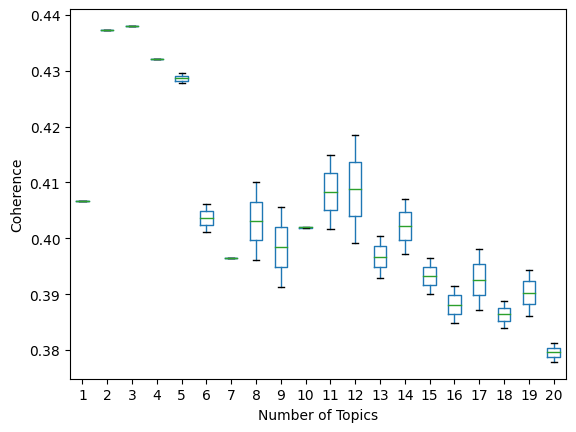

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,21,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["tweets"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

### Clustering

In [ ]:
m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

docs1 = pd.DataFrame(list(dataset["tweets"]), columns=["Doc"])
docs1['Topic'] = cluster_membership
docs1['Doc_ID'] = range(len(docs))
docs_per_topic = docs1.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

print(top_words)

[['is', 'for', 'you', 'on', 'and', 'what', 'this', 'to', 'of', 'it'], ['it', 'and', 'of', 'is', 'to', 'that', 'for', 'in', 'with', 'this'], ['ai', 'of', 'in', 'and', 'for', 'with', 'to', 'openai', 'it', 'the']]


In [ ]:
### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))

0.43802032022978415


In [ ]:
data_train['Topic']=docs1['Topic']

In [ ]:
data_train

,tweets,Topic
0,muting chatgpt,0
1,the conversation is here\n\nopenai\n#openaicha...,2
2,i asked chatgpt can you write me a jwt validat...,1
3,"chatgpt may pose a threat google's, $googl, ad...",1
4,chatgpt is the new quillbot.,1
...,...,...
6995,"when chatgpt introduces ads, how much worse wi...",0
6996,robots are better at this whole law thing than...,2
6997,ai can never replace human intellect. it is as...,1
6998,arguing with chatgpt.,0


In [ ]:
from google.colab import files
data_train.to_csv('data_train.csv', encoding = 'utf-8-sig') 
files.download('data_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Untuk Data Test

### Data Test

In [ ]:
dataset=data_test

### Representasi Topik dengan RoBERTa

In [ ]:
### RoBERTa Embedding
roberta_emb = np.array(roberta(dataset.to_numpy()))

print(roberta_emb.shape)

(1500, 768)


### Pendefinisian fungsi-fungsi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

### Tuning Hyperparameter

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(roberta_emb)

print(data.shape)

(1500, 5)


The number of topics is 1
The simulation 1
Coherence value :  0.4117076214816835
The simulation 2
Coherence value :  0.4117076214816835
The number of topics is 2
The simulation 1
Coherence value :  0.4371210076742702
The simulation 2
Coherence value :  0.4371210076742702
The number of topics is 3
The simulation 1
Coherence value :  0.43235100538090426
The simulation 2
Coherence value :  0.43235100538090426
The number of topics is 4
The simulation 1
Coherence value :  0.4225250664477547
The simulation 2
Coherence value :  0.42252506644775467
The number of topics is 5
The simulation 1
Coherence value :  0.4218962249822086
The simulation 2
Coherence value :  0.4218962249822087
The number of topics is 6
The simulation 1
Coherence value :  0.396973172117951
The simulation 2
Coherence value :  0.39701084251757024
The number of topics is 7
The simulation 1
Coherence value :  0.40711519334828505
The simulation 2
Coherence value :  0.40392511289676575
The number of topics is 8
The simulation 1


Text(0, 0.5, 'Coherence')

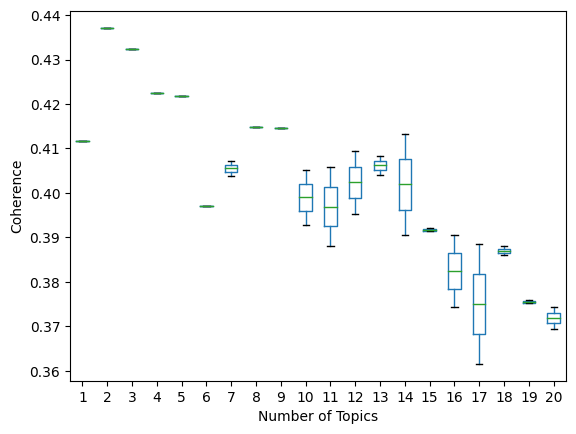

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,21,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["tweets"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

### Clustering

In [ ]:
m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

docs1 = pd.DataFrame(list(dataset["tweets"]), columns=["Doc"])
docs1['Topic'] = cluster_membership
docs1['Doc_ID'] = range(len(docs))
docs_per_topic = docs1.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

print(top_words)

[['is', 'with', 'for', 'on', 'you', 'this', 'of', 'can', 'how', 'to'], ['it', 'is', 'but', 'and', 'of', 'this', 'to', 'for', 'in', 'the'], ['and', 'ai', 'of', 'it', 'in', 'that', 'for', 'to', 'is', 'the']]


In [ ]:
### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))

0.43235100538090426


In [ ]:
data_test['Topic']=docs1['Topic']

In [ ]:
data_test

,tweets,Sentiment,Topic
0,chatgpt: unbelievable ai progress ! via,0,0
1,flat evil colors - dreamlike stablediffusion c...,0,0
2,chatgpt game changer!!,0,0
3,"ai right now is all style, no substance. you s...",1,2
4,did a robot write this? we need watermarks to ...,0,0
...,...,...,...
1495,is chatgpt down? i can't access it. chatgpt op...,0,0
1496,chatgpt: how to use this viral openai chatbot,0,0
1497,something something teach a man to fish someth...,0,2
1498,"i don't talk about the new chatgpt ai here, bu...",0,1


In [ ]:
from google.colab import files
data_test.to_csv('data_test.csv', encoding = 'utf-8-sig') 
files.download('data_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>